In [1]:
# Consider a variational family in which we:
# 1. sample a point from a Gaussian
# 2. find the nearest vertex of the simplex
# 3. move that point (1-tau) of the way toward the vertex

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.stats import multivariate_normal as mvn
from autograd.scipy.misc import logsumexp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [69]:
# Start with a simple GMM example
K = 2
D = 2
alpha = np.ones(K) / K
mus = npr.randn(D, K)
sigma = 1.0

# Sample a point
z = npr.choice(K, p=alpha)
x = mus[:,z] + npr.randn(D) * sigma

print(z)
print(mus)
print(x)

1
[[-0.87470495  0.10337208]
 [ 0.09022958  0.01730982]]
[-0.9514587  -0.20999261]


In [70]:
# Compute the true posterior
log_posterior = np.array([mvn.logpdf(x, mus[:,k], sigma*np.eye(D)) 
                          for k in range(K)])

log_posterior += np.log(alpha)
log_posterior -= logsumexp(log_posterior)
posterior = np.exp(log_posterior)
print(posterior)


[ 0.63045166  0.36954834]


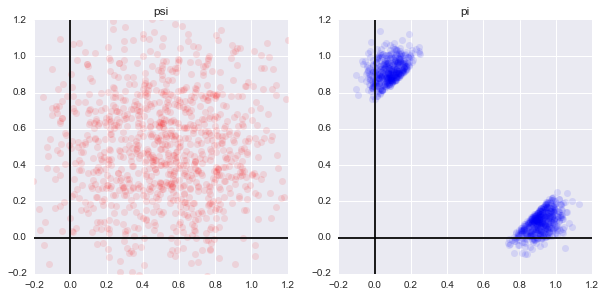

In [71]:
# Define this variational factor
def sample_q(m, v, tau):
    assert m.shape == (K,)
    assert v.shape == (K,K)
    psi = npr.multivariate_normal(m, v)
    k = np.argmax(psi)
    ek = np.zeros(K)
    ek[k] = 1
    z = (1-tau) * ek + tau * psi
    return z
    
# Test: sample a bunch of z's from q(z)
N = 1000
m = np.ones(K) / K
v = 0.1 * np.eye(K)
psis = npr.multivariate_normal(m, v, size=N)
qs = np.array([sample_q(m, v, 0.25) for _ in range(N)])

# Plot the points
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(psis[:,0], psis[:,1], 'ro', alpha=0.1)
plt.plot([0, 0], lims, '-k')
plt.plot(lims, [0, 0], '-k')
plt.xlim(lims)
plt.ylim(lims)
plt.gca().set_aspect(1.0)
plt.title("psi")

plt.subplot(122)
lims = (-0.2, 1.2)
plt.plot(qs[:,0], qs[:,1], 'bo', alpha=0.1)
plt.plot([0, 0], lims, '-k')
plt.plot(lims, [0, 0], '-k')
plt.xlim(lims)
plt.ylim(lims)
plt.gca().set_aspect(1.0)
plt.title("pi")

In [72]:
N_mc = 100
tau = 0.25
v = 0.1 * np.eye(K)

def expected_log_joint(m):
    # Sample pis from a variational family defined by a mean m in R^K
    pis = np.array([sample_q(m, v, tau) for _ in range(N_mc)])
    
    # Convert those pis (approx one-hot vectors) into means for x in R^D
    x_means = pis.dot(mus.T)
    
    # Compute the log likelihood probability of x given the mean
    log_joint = np.array([mvn.logpdf(x, x_mean, sigma*np.eye(D)) 
                          for x_mean in x_means])
    
    return np.mean(log_joint)
    
print(posterior)
print(expected_log_joint(np.array([1,0])))
print(mvn.logpdf(x, mus[:,0], sigma))
print(expected_log_joint(np.array([0,1])))
print(mvn.logpdf(x, mus[:,1], sigma))
print(expected_log_joint(np.array([0.5,0.5])))


[ 0.63045166  0.36954834]
-1.8923707055
-1.88588931482
-2.4208597131
-2.42004425096
-2.12634057485


In [93]:
# Lay down a grid of m's on R^K and find the expected log joint for each
# value of variataional mean, m
from pybasicbayes.util.text import progprint_xrange

# m1s = np.linspace(0.5, 1.5, 25)
# m2s = np.linspace(-0.5, 0.5, 25)
m1s = np.linspace(0, 1, 25)
m2s = np.linspace(0, 1, 25)
M1, M2 = np.meshgrid(m1s, m2s)
Ms = np.column_stack((M1.ravel(), M2.ravel()))
Ls = [expected_log_joint(Ms[i]) for i in progprint_xrange(Ms.shape[0])]
Ls = np.reshape(Ls, M1.shape)



.........................  [  25/625,    0.03sec avg, ETA 20.06 ]
.........................  [  50/625,    0.03sec avg, ETA 17.87 ]
.........................  [  75/625,    0.03sec avg, ETA 17.13 ]
.........................  [ 100/625,    0.03sec avg, ETA 16.73 ]
.........................  [ 125/625,    0.03sec avg, ETA 15.81 ]
.........................  [ 150/625,    0.03sec avg, ETA 15.10 ]
.........................  [ 175/625,    0.03sec avg, ETA 14.36 ]
.........................  [ 200/625,    0.03sec avg, ETA 13.64 ]
.........................  [ 225/625,    0.03sec avg, ETA 12.77 ]
.........................  [ 250/625,    0.03sec avg, ETA 12.03 ]
.........................  [ 275/625,    0.03sec avg, ETA 11.25 ]
.........................  [ 300/625,    0.03sec avg, ETA 10.51 ]
.........................  [ 325/625,    0.03sec avg, ETA 9.70 ]
.........................  [ 350/625,    0.03sec avg, ETA 8.86 ]
.........................  [ 375/625,    0.03sec avg, ETA 8.05 ]
.............

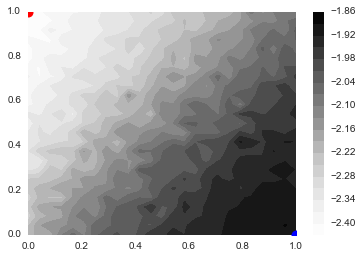

In [97]:
# View
plt.contourf(M1, M2, Ls, 20)
# plt.contour(M1, M2, Ls, 50)
plt.plot(0, 1, 'ro', markersize=10)
plt.plot(1, 0, 'bo', markersize=10)
plt.colorbar()